In [11]:
import os
import time
import math
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import torch
from model import GPTConfig, GPT

In [2]:
# -----------------------------------------------------------------------------
# Configuration values (keep or adjust as needed)
batch_size = 24
block_size = 256
n_layer = 8
n_head = 8
n_embd = 32
dropout = 0.0
bias = False

learning_rate = 1e-3
max_iters = 1000

gradient_accumulation_steps = 20
weight_decay = 1e-1
beta1 = 0.9
beta2 = 0.95
grad_clip = 1.0
decay_lr = True
warmup_iters = 100
lr_decay_iters = 900
min_lr = 6e-4


out_dir = 'out'
eval_interval = 20
# log_interval = 1
eval_iters = 100
eval_only = False
always_save_checkpoint = True
init_from = 'scratch'

wandb_log = False
# wandb_project = 'owt'
# wandb_run_name = 'gpt2'
# dataset = 'openwebtext'

compile = False
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'

if torch.cuda.is_available():
    gpu_id = '6' # select a single GPU
    # gpu_id = '2,3' # select multiple GPUs
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
    device = torch.device("cuda")
    print('GPU name: {:s}, gpu_id: {:s}'.format(torch.cuda.get_device_name(0),gpu_id))

else:
    device = torch.device("cpu")
    gpu_id = -1 # select CPU
# -----------------------------------------------------------------------------

# Override config with command line/config file values (skipped for brevity)
# config = { ... }

GPU name: Tesla V100-SXM2-16GB, gpu_id: 6


In [3]:
# Initial setup
os.makedirs(out_dir, exist_ok=True)
torch.manual_seed(1337)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
device_type = 'cuda' #if 'cuda' in device else 'cpu'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = torch.amp.autocast(device_type=device_type, dtype=ptdtype) if device_type == 'cuda' else nullcontext()

In [4]:
# Data loading and preprocessing setup 
with open('input.txt', 'r', encoding='utf-8') as f:
    data = f.read()

chars = sorted(list(set(data)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(data), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [5]:
# Save to binary files
train_data.numpy().tofile('data_bin/train_data.bin')
val_data.numpy().tofile('data_bin/val_data.bin')

data_dir = 'data_bin'
train_data = np.memmap(os.path.join(data_dir, 'train_data.bin'), dtype=np.uint16, mode='r')
val_data = np.memmap(os.path.join(data_dir, 'val_data.bin'), dtype=np.uint16, mode='r')

In [6]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

In [7]:
# Model and optimizer setup
# model init
# meta_vocab_size = None
model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                  bias=bias, vocab_size=None, dropout=dropout) # start with model_args from command line
if init_from == 'scratch':
    # init a new model from scratch
    print("Initializing a new model from scratch")
    # determine the vocab size we'll use for from-scratch training
#     if meta_vocab_size is None:
#         print("defaulting to vocab_size of GPT-2 to 50304 (50257 rounded up for efficiency)")
    model_args['vocab_size'] = vocab_size #meta_vocab_size if meta_vocab_size is not None else 50304
    gptconf = GPTConfig(**model_args)
    model = GPT(gptconf)
elif init_from == 'resume':
    print(f"Resuming training from {out_dir}")
    # resume training from a checkpoint.
    ckpt_path = os.path.join(out_dir, 'ckpt.pt')
    checkpoint = torch.load(ckpt_path, map_location=device)
    checkpoint_model_args = checkpoint['model_args']
    # force these config attributes to be equal otherwise we can't even resume training
    # the rest of the attributes (e.g. dropout) can stay as desired from command line
    for k in ['n_layer', 'n_head', 'n_embd', 'block_size', 'bias', 'vocab_size']:
        model_args[k] = checkpoint_model_args[k]
    # create the model
    gptconf = GPTConfig(**model_args)
    model = GPT(gptconf)
    state_dict = checkpoint['model']
    # fix the keys of the state dictionary :(
    # honestly no idea how checkpoints sometimes get this prefix, have to debug more
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict)
    iter_num = checkpoint['iter_num']
    best_val_loss = checkpoint['best_val_loss']

Initializing a new model from scratch
number of parameters: 0.10M


In [8]:
# crop down the model block size if desired, using model surgery
if block_size < model.config.block_size:
    model.crop_block_size(block_size)
    model_args['block_size'] = block_size # so that the checkpoint will have the right value
model.to(device)

# initialize a GradScaler. If enabled=False scaler is a no-op
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

# optimizer
optimizer = model.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device_type)
if init_from == 'resume':
    optimizer.load_state_dict(checkpoint['optimizer'])
checkpoint = None # free up memory

# compile the model
if compile:
    print("compiling the model... (takes a ~minute)")
    unoptimized_model = model
    model = torch.compile(model) # requires PyTorch 2.0

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

num decayed parameter tensors: 34, with 108,576 parameters
num non-decayed parameter tensors: 17, with 544 parameters
using fused AdamW: True


In [9]:
# TQDM training loop
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
# local_iter_num = 0 # number of iterations in the lifetime of this process
running_mfu = -1.0
iter_num = 0
best_val_loss = 1e9

train_losses = []
val_losses = []

pbar = tqdm(range(max_iters), desc="Training Progress")

for iter_num in pbar:
    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # evaluate the loss on train/val sets and write checkpoints
    if iter_num % eval_interval == 0:
        
        losses = estimate_loss()
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        
        pbar.set_description(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        if wandb_log:
            wandb.log({
                "iter": iter_num,
                "train/loss": losses['train'],
                "val/loss": losses['val'],
                "lr": lr,
                "mfu": running_mfu*100, # convert to percentage
            })
        if losses['val'] < best_val_loss or always_save_checkpoint:
            best_val_loss = losses['val']
            if iter_num > 0:
                checkpoint = {
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'model_args': model_args,
                    'iter_num': iter_num,
                    'best_val_loss': best_val_loss,
                    'train_losses': train_losses,
                    'val_losses': val_losses,
#                     'config': config,
                }
#                 print(f"saving checkpoint to {out_dir}")
                torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))
    if iter_num == 0 and eval_only:
        break

    # forward backward update, with optional gradient accumulation to simulate larger batch size
    # and using the GradScaler if data type is float16
    for micro_step in range(gradient_accumulation_steps):
        with ctx:
            logits, loss = model(X, Y)
            loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
        # immediately async prefetch next batch while model is doing the forward pass on the GPU
        X, Y = get_batch('train')
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()
    # clip the gradient
    if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # step the optimizer and scaler if training in fp16
    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)

    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1

step 980: train loss 0.6973, val loss 0.7002: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [14:43<00:00,  1.13it/s]


In [13]:
checkpoint = torch.load(os.path.join(out_dir, 'ckpt.pt'))
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']
train_losses_np = np.array(train_losses)
val_losses_np = np.array(val_losses)

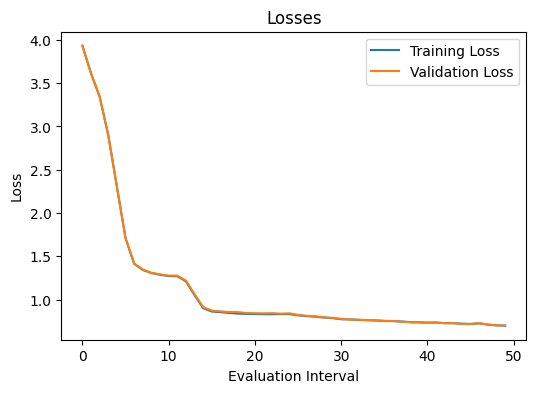

In [14]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses_np, label='Training Loss')
plt.plot(val_losses_np, label='Validation Loss')
plt.xlabel('Evaluation Interval')
plt.ylabel('Loss')
plt.title('Losses')
plt.legend()
plt.show()